In [2]:
import os
import math
import random
import operator
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import math, itertools

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from operator import itemgetter

In [25]:
# Helper Functions ...

def load_file(data_file_path):
    data_df = pd.read_csv(data_file_path, delimiter=";")
    return data_df


def compute_reward_individual(num_calls, result, cost_per_call = 1):
    if result == "yes":
        return (21 - (cost_per_call * num_calls))
    elif result == "no":
        return (-1 * (cost_per_call * num_calls))
    

def compute_y_position_label(y_val):
    if y_val >= 0.0:
        return 'bottom'
    else:
        return 'top'
    

def div(a,b):
    if int(b) == 0:
        return 0.0
    else:
        return a/b
        

def plot_graph(x, y, key, bar_plot, digregard_x_axis):
    style = dict(size=8, color='red')
    new_x = []
    if digregard_x_axis:
        for i in range(1, len(x)+1):
            new_x.append(i)
    else:
        new_x = x
    fig, ax = plt.subplots(figsize = (14, 6))
    # plt.xticks(np.arange(len(x)), x, rotation=75)
    # ax.tick_params(axis='x', which='major', pad=20)
    if bar_plot:
        ax.bar(new_x, y, 0.75)
    else:
        # plt.xlim((x[0],x[-1]))
        ax.plot(x, y)
    if digregard_x_axis:
        for i in range(1, len(x)+1):
            ax.text(i, y[i-1], x[i-1], ha='center', verticalalignment=compute_y_position_label(y[i-1]), **style)
        ax.axes.get_xaxis().set_visible(False)
    else:
        for i in range(1, len(x)+1):
            ax.text(x[i-1], y[i-1], y[i-1], ha='center', verticalalignment=compute_y_position_label(y[i-1]), **style)
    # Setting title and labels.
    title = "Expected reward vs " +  str(key)
    ax.set(xlabel=str(key), ylabel='Expected Reward', title=title)
    # plt.axvline(x=0, color ="black")
    plt.axhline(y=0, color ="black")
    # ax.grid()
    plt.tight_layout()
    plt.show()
    

def plot_graph_balance(x, y, key, step):
    style = dict(size=8, color='black')
    fig, ax = plt.subplots(figsize = (14, 6))
    # plt.xticks(np.arange(len(x)), x, rotation=75)
    # ax.tick_params(axis='x', which='major', pad=20)
    ax.bar(x, y, 0.75)
    # Setting title and labels.
    title = "Expected reward vs " +  str(key)
    ax.set(xlabel= "Average yearly balance", ylabel='Expected Reward', title=title)
    # plt.axvline(x=0, color ="black")
    plt.axhline(y=0, color ="black")
    # ax.grid()
    plt.tight_layout()
    tick_labels = ['-ve', '-ve', '-ve']
    for i in range (1, len(x)+1):
        tick_labels.append(str((i-1)*step) +'-' + str(i * step))
    ax.set_xticklabels(tick_labels ,rotation='vertical')
    plt.show()


def analyze_results(reward_values_list_sorted):
    num_pos = 0
    num_neg = 0
    num_pos_avg = 0.0
    num_neg_avg = 0.0
    for item in reward_values_list_sorted:
        ref = item[1]
        if ref['expected'] >= 0.0:
            num_pos += 1
            num_pos_avg += ref['expected']
        else:
            num_neg += 1
            num_neg_avg += ref['expected']
    print("# Positive: ", num_pos)
    print("# Negative:", num_neg)
    print("Pos - Avg. Expected:", div(num_pos_avg,num_pos))
    print("Neg - Avg. Expected:", div(num_neg_avg,num_neg))
    
    
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = iterable
    return itertools.chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def construct_dict(feature_comb):
    new_dict = {}
    new_dict['education'] = feature_comb[0]
    new_dict['job'] = feature_comb[2]
    new_dict['marital'] = feature_comb[1]
    new_dict['default'] = feature_comb[3]
    new_dict['loan'] = feature_comb[4]
    new_dict['housing'] = feature_comb[5]
    return new_dict


def is_all_zero(arr):
    for item in arr:
        if item != 0.0:
            return False
    return True


def find_max_min_locs(arr):
    max_value = max(my_list)
    max_index = my_list.index(max_value)
    min_value = min(my_list)
    min_index = my_list.index(max_value)
    return (max_value, max_index, min_value, min_index)

In [26]:
# This function takes the data corresponding to a feature set and computes the expected values for calls
# ranging from 1 ..  num_calls.
def compute_expected_reward_feature_set(fs_df, no_calls):
    expected_values_calls = []
    for i in range(0, no_calls):
        expected_values_calls.append({'value':0.0, 'count':0, 'expected':0.0})
    for index, row in fs_df.iterrows():
        expected_values_calls[row['campaign']-1]['value'] += compute_reward_individual(row['campaign'], row['y'])
        expected_values_calls[row['campaign']-1]['count'] += 1
    for i in range(0, no_calls):
        expected_values_calls[i]['expected'] = div(expected_values_calls[i]['value'], expected_values_calls[i]['count'])
    return expected_values_calls


# Given a dictionary of what attributes comprise a feature set, we can get all rows corresponding to this feature set.
def extract_rows_feature_set(fs_df, feature_labels = {'education':['tertiary', 'unknown'], 
                                                      'job':['management', 'technician', 'blue-collar'], 
                                                      'marital':['single'], 'default':['no'], 
                                                      'housing':['no'], 'loan':['no']}):
    for key in feature_labels:
        feature_labels_query_str = ''
        arr = feature_labels[key]
        for label in arr:
            feature_labels_query_str += (key + ' == "'+ label + '" | ')
        feature_labels_query_str = feature_labels_query_str[:-3]
        fs_df = fs_df.query(feature_labels_query_str)
    return fs_df

In [27]:
# Constructing all possible combinations.
poss = []
poss.append([['tertiary', 'unknown'],['primary','secondary']])
poss.append([['single'],['married'],['divorced']])
poss.append([['student','retired','unemployed'],['admin', 'management', 'self-employed'],['technician', 'unknown', 'services'],['housemaid', 'blue-collar', 'entrepreneur']])
poss.append([['no'],['yes']])
poss.append([['no'],['yes']])
poss.append([['no'],['yes']])
all_combs = list(itertools.product(*poss))

# Age query strings.
age_query_strings = ['age < 26','age >= 26 & age <=60','age >60']

# Balance query strings.
balance_query_strings = ['balance <= 5000',' balance > 5000']

#Max call number to consider.
max_calls = 20

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'unemployed'], ['no'], ['no'], ['no'])
[9.30188679245283, 7.8, 2.25, 4.4, 16.0, 0.0, -7.0, 0.0, 0.0, 0.0, 0.0, -12.0, 0.0, 0.0, 0.0, 0.0, 0.0, -18.0, 0.0, 0.0]


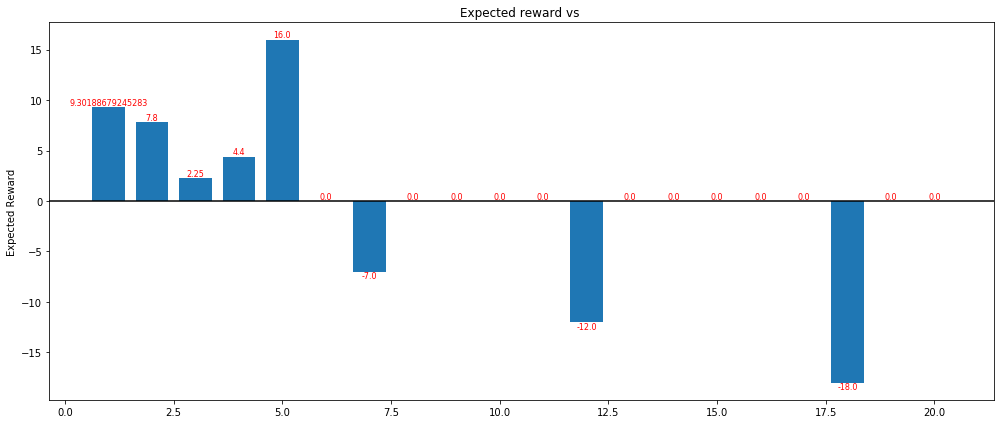

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'unemployed'], ['no'], ['no'], ['yes'])
[-1.0, 1.5, -3.0, 0.0, -5.0, 0.0, 0.0, 0.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


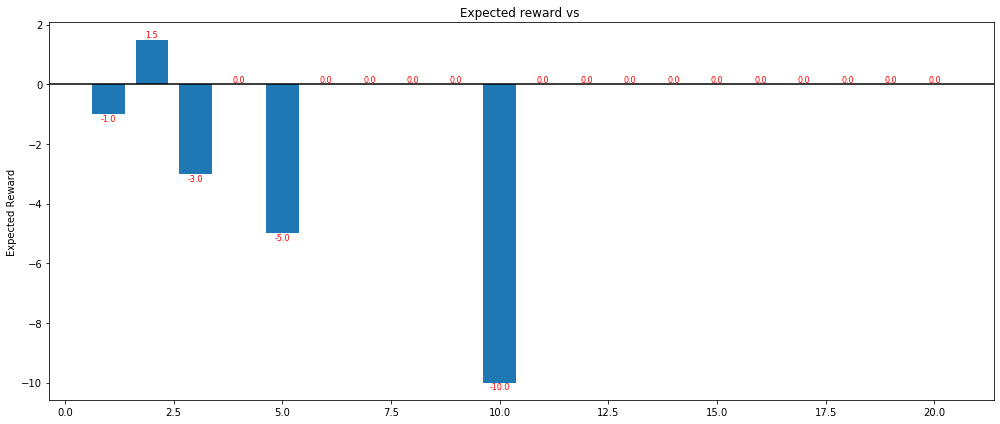

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'unemployed'], ['no'], ['yes'], ['no'])
[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


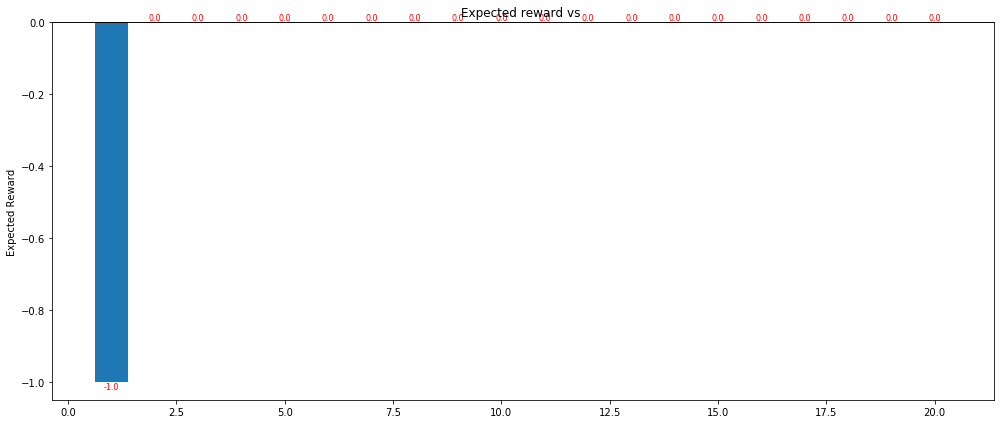

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'unemployed'], ['no'], ['yes'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'unemployed'], ['yes'], ['no'], ['no'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'unemployed'], ['yes'], ['no'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'unemployed'], ['yes'], ['yes'], ['no'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['student', 'retired', 'un

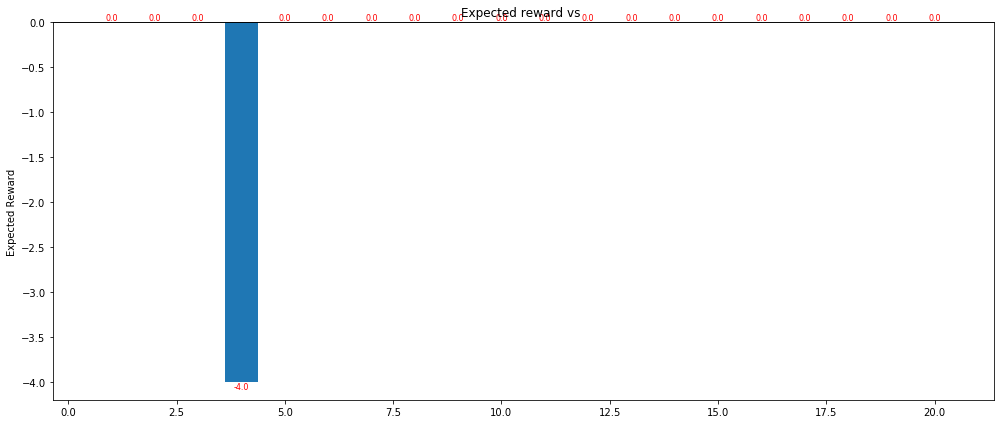

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['no'], ['no'], ['no'])
[6.0, 6.166666666666667, 7.5, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


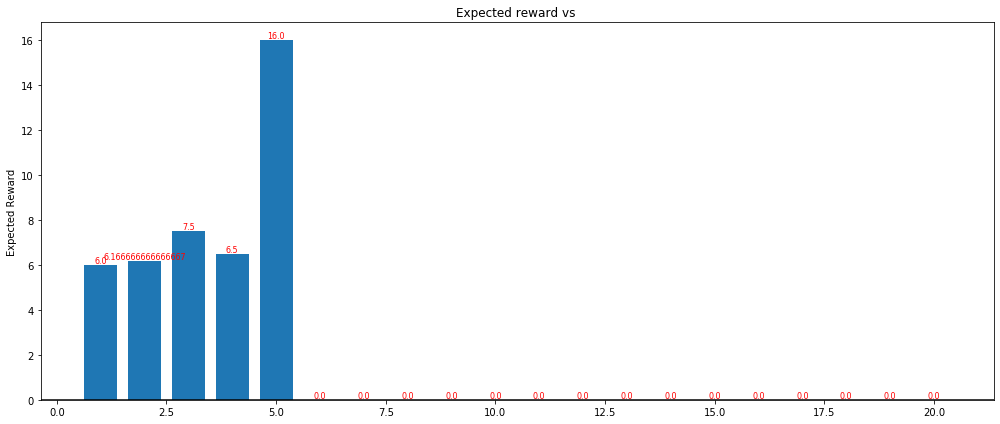

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['no'], ['no'], ['yes'])
[3.5, 0.3333333333333333, -3.0, -4.0, -5.0, -6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


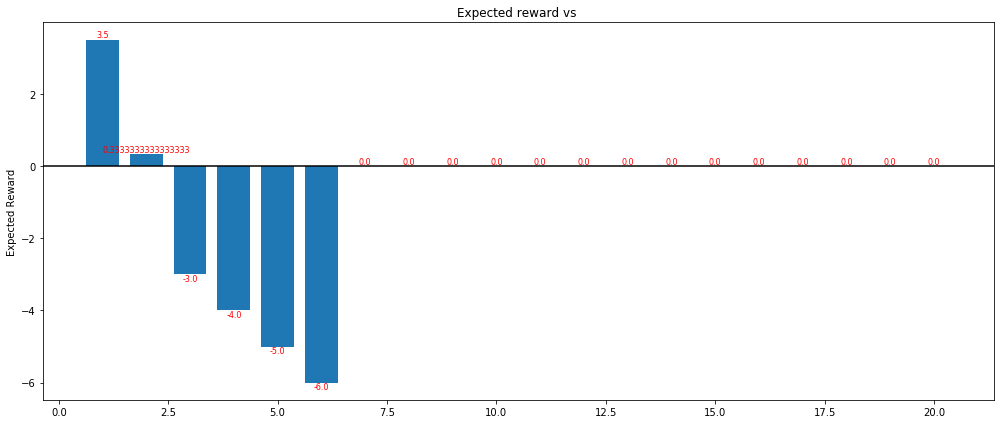

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['no'], ['yes'], ['no'])
[2.5, -2.0, 18.0, 0.0, 0.0, -6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


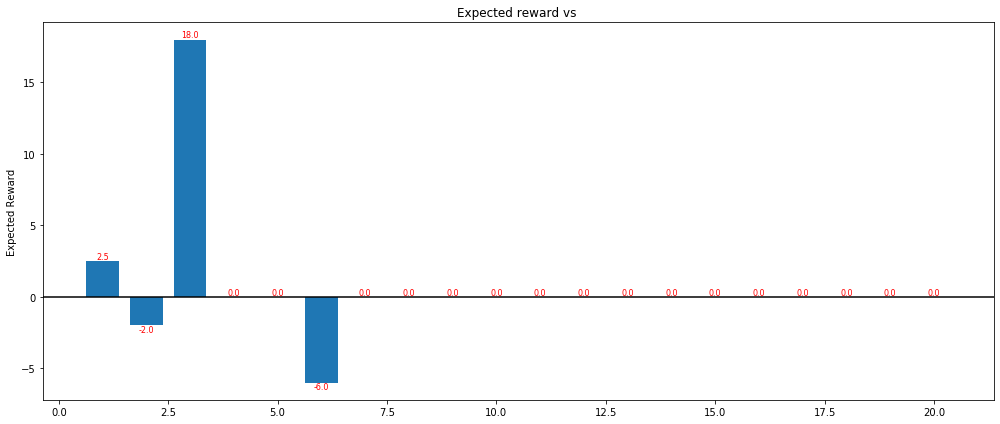

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['no'], ['yes'], ['yes'])
[6.0, 0.0, 0.0, -4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


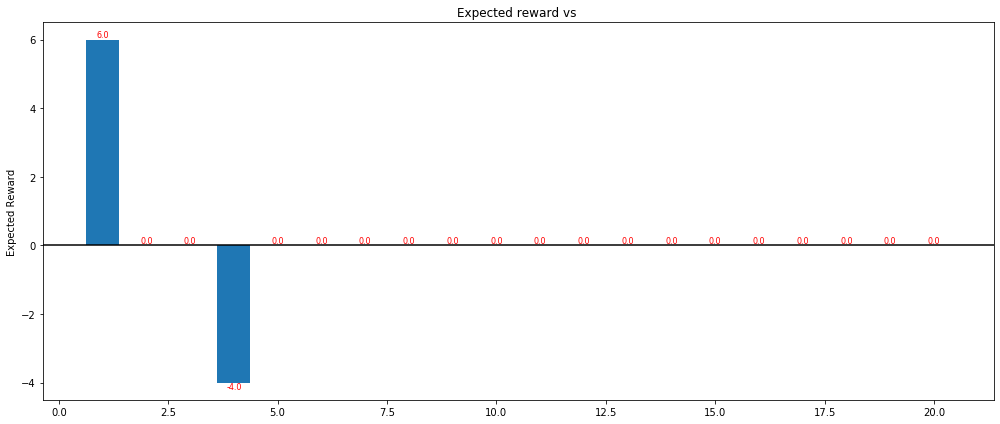

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['yes'], ['no'], ['no'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['yes'], ['no'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['yes'], ['yes'], ['no'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['admin', 'management', 'self-employed'], ['yes'], ['yes'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technic

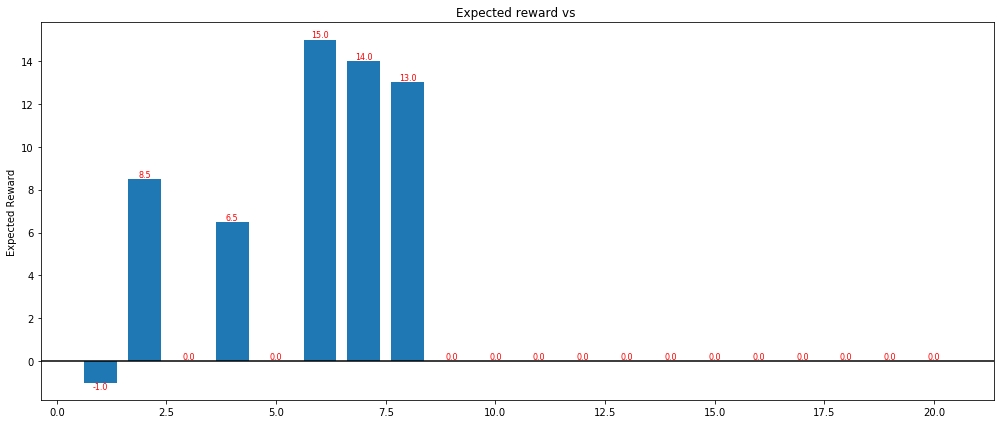

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technician', 'unknown', 'services'], ['no'], ['no'], ['yes'])
[1.625, -2.0, -3.0, -4.0, 0.0, -6.0, -7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -18.0, 0.0, 0.0]


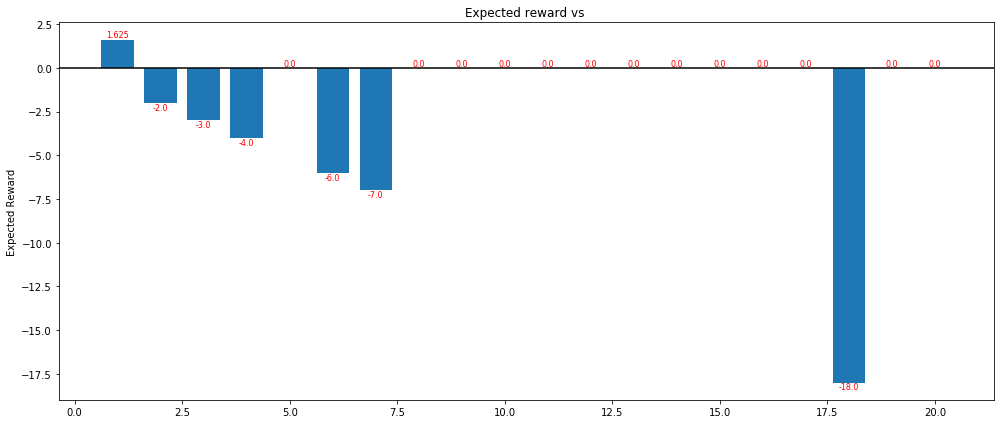

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technician', 'unknown', 'services'], ['no'], ['yes'], ['no'])
[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


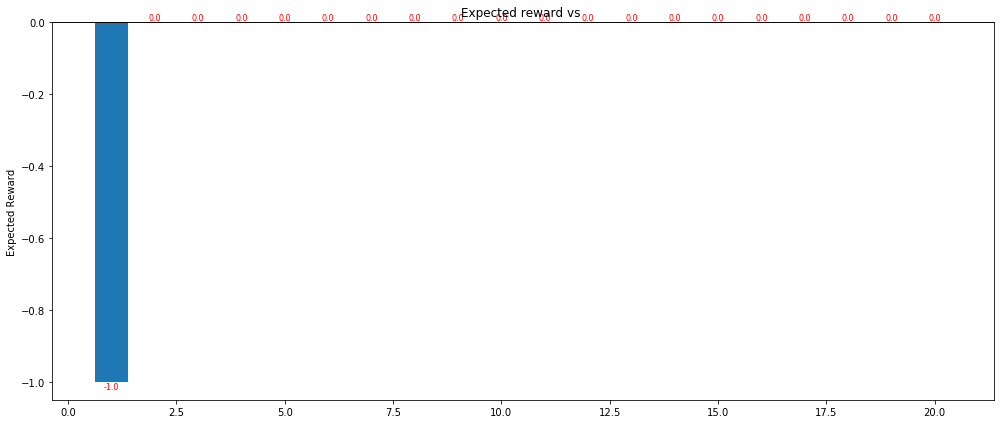

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technician', 'unknown', 'services'], ['no'], ['yes'], ['yes'])
[-1.0, 0.0, -3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


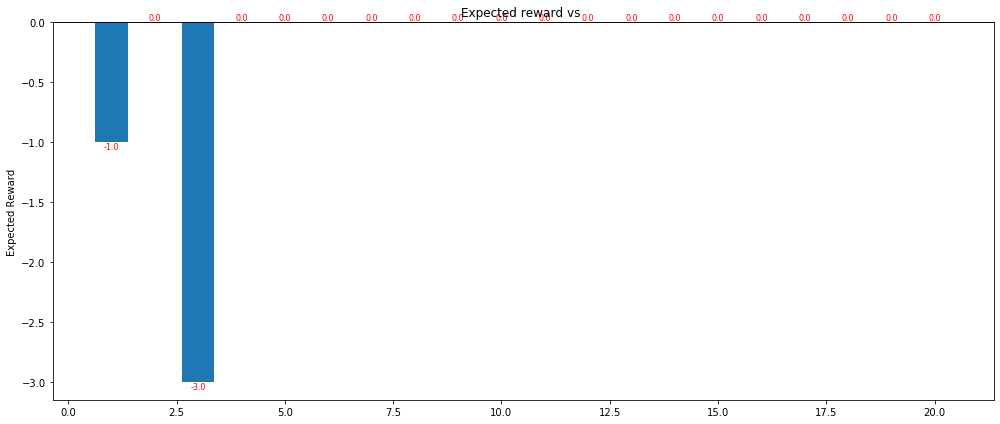

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technician', 'unknown', 'services'], ['yes'], ['no'], ['no'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technician', 'unknown', 'services'], ['yes'], ['no'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technician', 'unknown', 'services'], ['yes'], ['yes'], ['no'])
[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


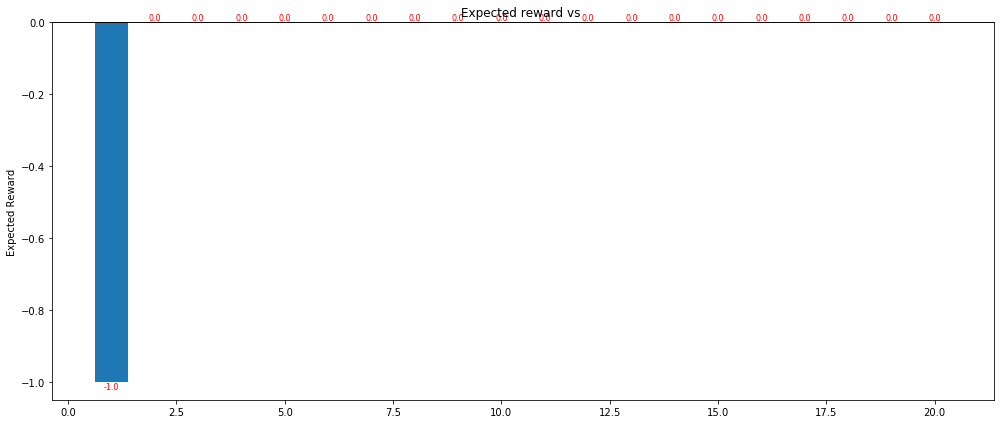

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['technician', 'unknown', 'services'], ['yes'], ['yes'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['housemaid', 'blue-collar', 'entrepreneur'], ['no'], ['no'], ['no'])
[9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


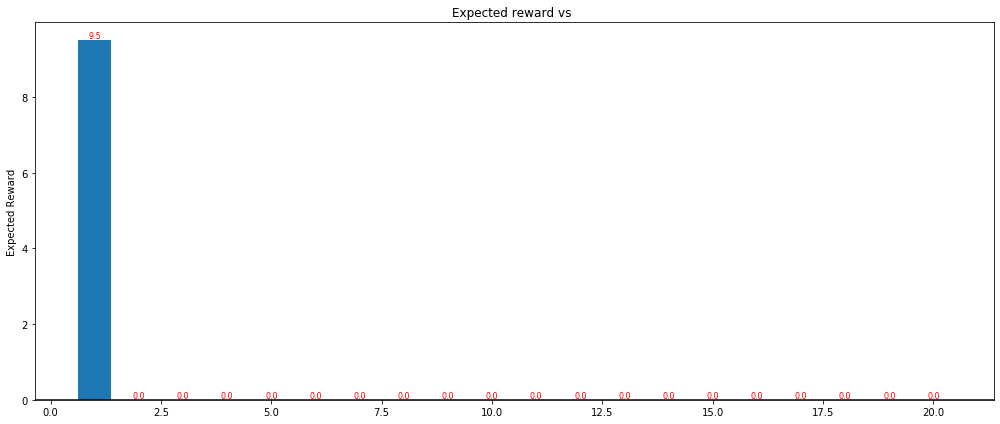

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['housemaid', 'blue-collar', 'entrepreneur'], ['no'], ['no'], ['yes'])
[-1.0, -2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


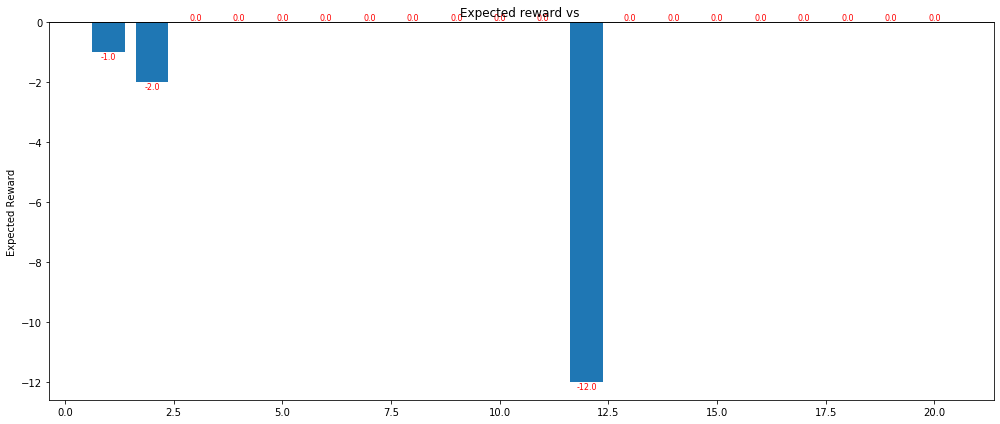

age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['housemaid', 'blue-collar', 'entrepreneur'], ['no'], ['yes'], ['no'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['housemaid', 'blue-collar', 'entrepreneur'], ['no'], ['yes'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['housemaid', 'blue-collar', 'entrepreneur'], ['yes'], ['no'], ['no'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['single'], ['housemaid', 'blue-collar', 'entrepreneur'], ['yes'], ['no'], ['yes'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
age < 26 balance <= 5000 (['tertiary', 'unknown'], ['singl

KeyboardInterrupt: 

<Figure size 1008x432 with 0 Axes>

In [28]:
# Pull and filter all calls <= 20.
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=max_calls)]

# Setting up looing structures to iterate all possibilities.
num_iter = 0
for age_query in age_query_strings:
    df_filtered_final = mkt_df_filtered.query(age_query)
    for bal_query in balance_query_strings:
        df_filtered_final = df_filtered_final.query(bal_query)
#         Manual query for testing purposes.
#         print("Length of manual query: ", len(df_filtered_final.query('(education == "tertiary" | education == "unknown") and (marital == "single") and (job == "student" | job == "retired" | job == "unemployed") and (housing == "no") and (loan == "no") and (default == "no")')))
        for comb in all_combs:
            print(age_query, bal_query, comb)
            dict_final_query = construct_dict(comb)
            num_iter += 1
            extracted_df = extract_rows_feature_set(df_filtered_final, dict_final_query)
            results = compute_expected_reward_feature_set(extracted_df, max_calls)
            x = [i for i in range(1,len(results)+1)]
            y = [item['expected'] for item in results]
            print(y)
            if not is_all_zero(y):
                plot_graph(x, y, '', True, False)
#             print(len(extracted_df))
#             break
print("Number of combs iterated: ", num_iter)

In [ ]:
# Writing a manual query for testing purposes.
